# Multi-Store Sales Forecasting using XGBoost

## Introduction

This notebook is an extension of an ongoing data science project focused on exploring basic time series forecasting methodologies. The primary objective of this phase is to develop and evaluate a multi-store sales forecasting model using the XGBoost regressor framework.

Previously, our analysis was limited to individual store sales data, using frameworks such as SARIMAX, Prophet, and XGBoost regressor. These methods provided foundational insights into the dynamics of time series forecasting in a retail context.

In this phase, we will expand our scope to encompass multiple stores, aiming to capture the complexities and interactions in sales patterns across different locations.

# Imports

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/RossmannSalesForecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Data Loading

As we're working with different stores now, it's wise to additionally load the `StoreType` feature, so we can have a mechanism to different the behavior of one type of store to another.

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)[["Store", "StoreType", "StateHoliday", "Promo", "Sales"]]

## Feature Engineering

We'll again aggregate data into weekly totals, also taking care of the `StoreType` feature.

In [4]:
stores_sales_df["StateHoliday"] = stores_sales_df["StateHoliday"].map(
    {"0": 0, "a": 1, "b": 2, "c": 3}
)

stores_sales_df["StoreType"] = stores_sales_df["StoreType"].map(
    {"a": 0, "b": 1, "c": 2, "d": 3}
)

stores_sales_df

,Store,StoreType,StateHoliday,Promo,Sales
Date,,,,,
2013-01-01,1115,3,1,0,0
2013-01-01,746,3,1,0,0
2013-01-01,171,0,1,0,0
2013-01-01,694,0,1,0,0
2013-01-01,396,0,1,0,0
...,...,...,...,...,...
2015-07-31,612,3,0,1,8161
2015-07-31,235,0,0,1,6756
2015-07-31,1078,3,0,1,9732


In [5]:
weekly_stores_sales_df = stores_sales_df.groupby("Store").resample("W").agg({
    "Sales": "sum",
    "StateHoliday": "max",
    "Promo": "max",
    "StoreType": "max"
}).reset_index()

weekly_stores_sales_df

,Store,Date,Sales,StateHoliday,Promo,StoreType
0,1,2013-01-06,19340,1.0,0.0,2.0
1,1,2013-01-13,32952,0.0,1.0,2.0
2,1,2013-01-20,25978,0.0,0.0,2.0
3,1,2013-01-27,33071,0.0,1.0,2.0
4,1,2013-02-03,28693,0.0,0.0,2.0
...,...,...,...,...,...,...
150520,1115,2015-07-05,48130,0.0,1.0,3.0
150521,1115,2015-07-12,36233,0.0,0.0,3.0
150522,1115,2015-07-19,45927,0.0,1.0,3.0
150523,1115,2015-07-26,35362,0.0,0.0,3.0


### Extract a validation set

We'll keep all data from year **2015** as validation set to evaluate our forecasts.

In [6]:
validation_weekly_stores_sales_df = weekly_stores_sales_df[
    weekly_stores_sales_df.Date > "2015-02"
]
weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date < "2015-02"]

### Data Transformation

We'll, once again, **standardize** the `Sales` feature and apply **One-Hot Encoding** to `StateHoliday`.

In [7]:
sales_transform = StandardScaler()

weekly_stores_sales_df["Sales"] = sales_transform.fit_transform(
    weekly_stores_sales_df[["Sales"]]
).squeeze()
weekly_stores_sales_df = pd.get_dummies(
    weekly_stores_sales_df, columns=["StateHoliday"]
)

### Time-related Features

In [8]:
weekly_stores_sales_df["Year"] = weekly_stores_sales_df["Date"].dt.year
weekly_stores_sales_df["Month"] = weekly_stores_sales_df["Date"].dt.month
weekly_stores_sales_df["WeekOfYear"] = weekly_stores_sales_df["Date"].dt.isocalendar().week

### Lag and Rolling Mean Features

We'll also create columns for the 4 weeks of sales data and a column for the rolling average of the last 4 weeks of sales.

In [9]:
weekly_stores_sales_df["Sales_Lag1"] = weekly_stores_sales_df.groupby("Store")[
    "Sales"
].shift(1)
weekly_stores_sales_df["Sales_Lag2"] = weekly_stores_sales_df.groupby("Store")[
    "Sales"
].shift(2)
weekly_stores_sales_df["Sales_Lag3"] = weekly_stores_sales_df.groupby("Store")[
    "Sales"
].shift(3)
weekly_stores_sales_df["Sales_Lag4"] = weekly_stores_sales_df.groupby("Store")[
    "Sales"
].shift(4)

weekly_stores_sales_df["Sales_4Week_Avg"] = (
    weekly_stores_sales_df.groupby("Store")["Sales"]
    .rolling(window=4)
    .mean()
    .shift(1)
    .reset_index(drop=True)
)

weekly_stores_sales_df = weekly_stores_sales_df.dropna()
weekly_stores_sales_df

,Store,Date,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_Lag3,Sales_Lag4,Sales_4Week_Avg
4,1,2013-02-03,-0.538658,0.0,2.0,True,False,False,False,2013,2,5,-0.297333,-0.688314,-0.303893,-1.054214,-0.585939
5,1,2013-02-10,-0.148504,1.0,2.0,True,False,False,False,2013,2,6,-0.538658,-0.297333,-0.688314,-0.303893,-0.457049
6,1,2013-02-17,-0.583472,0.0,2.0,True,False,False,False,2013,2,7,-0.148504,-0.538658,-0.297333,-0.688314,-0.418202
7,1,2013-02-24,-0.303948,1.0,2.0,True,False,False,False,2013,2,8,-0.583472,-0.148504,-0.538658,-0.297333,-0.391992
8,1,2013-03-03,-0.630491,0.0,2.0,True,False,False,False,2013,3,9,-0.303948,-0.583472,-0.148504,-0.538658,-0.393645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120388,892,2014-12-28,0.045966,0.0,0.0,False,False,False,True,2014,12,52,2.205702,0.377691,1.387471,1.102104,-0.080690
120389,892,2015-01-04,-0.395451,0.0,0.0,False,True,False,False,2015,1,1,0.045966,2.205702,0.377691,1.387471,-0.083184
120390,892,2015-01-11,0.642662,1.0,0.0,True,False,False,False,2015,1,2,-0.395451,0.045966,2.205702,0.377691,-0.125642
120391,892,2015-01-18,0.510314,1.0,0.0,True,False,False,False,2015,1,3,0.642662,-0.395451,0.045966,2.205702,-0.105564


# Model Building

We'll once again begin with a simple XGBoost model with default parameters. Let's first introduce some randomness to the training data.

In [10]:
shuffled_weekly_stores_sales_df = weekly_stores_sales_df.copy()

shuffled_weekly_stores_sales_df["rnd_index"] = np.random.default_rng(seed=42).permutation(
    len(shuffled_weekly_stores_sales_df)
)

shuffled_weekly_stores_sales_df = (
    shuffled_weekly_stores_sales_df
        .set_index("rnd_index")
        .sort_index()
        .drop("Date", axis="columns")
)

shuffled_weekly_stores_sales_df

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_Lag3,Sales_Lag4,Sales_4Week_Avg
rnd_index,,,,,,,,,,,,,,,,
0,838,0.819494,1.0,3.0,True,False,False,False,2014,2,6,0.072370,0.680917,-0.063285,0.857914,-0.458510
1,552,-0.280135,0.0,0.0,True,False,False,False,2014,10,42,1.065503,0.598950,-0.441698,0.813816,-0.398620
2,316,0.372785,0.0,3.0,True,False,False,False,2013,2,5,1.039596,0.226987,1.412937,-0.356094,0.574490
3,336,2.765356,1.0,0.0,True,False,False,False,2014,8,32,3.042675,1.534536,2.594753,1.613692,-0.817217
4,721,0.159793,0.0,0.0,True,False,False,False,2013,11,44,0.316119,-0.083019,0.311875,-0.138692,-0.005214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87214,736,-0.874351,0.0,2.0,True,False,False,False,2013,9,38,0.083064,-0.622278,-0.367835,-0.821654,-0.461762
87215,801,-0.144590,1.0,3.0,True,False,False,False,2014,7,27,-0.848609,-0.305712,-0.822977,-0.056340,-0.478864
87216,178,0.351067,0.0,3.0,True,False,False,False,2014,3,9,1.449263,0.530213,1.909201,0.490856,-0.619949


Then we separate the target Sales feature...

In [11]:
train_features, train_sales = (
    shuffled_weekly_stores_sales_df.drop("Sales", axis="columns").values,
    shuffled_weekly_stores_sales_df[["Sales"]].values,
)

and train our model.

In [12]:
xgbr_regressor = XGBRegressor()
xgbr_regressor.fit(train_features, train_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

And here's the training error.

In [13]:
mae = mean_absolute_error(train_sales, xgbr_regressor.predict(train_features))
mse = mean_squared_error(train_sales, xgbr_regressor.predict(train_features))

print(f"Train MAE: {mae:.4} -- Train MSE: {mse:.4}")

Train MAE: 0.105 -- Train MSE: 0.02521


## Check Results on Validation Set

### Feature engineering functions

We'll basically import all feature engineering functions define in the last notebook.

In [14]:
def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Year"] = df_copy.index.year
    df_copy["Month"] = df_copy.index.month
    df_copy["WeekOfYear"] = df_copy.index.isocalendar().week
    return df_copy

In [15]:
def extract_dummy_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = pd.get_dummies(df, columns=["StateHoliday"])
    for i in range(4):
        feature_name = f"StateHoliday_{i}.0"
        if feature_name not in df_copy.columns:
            df_copy[feature_name] = False
    return df_copy

In [16]:
def extract_historic_features(df: pd.Series, history_df: pd.DataFrame, window: int = 2) -> pd.Series:
    df_copy = df.copy()
    lags = history_df.Sales.values[-4:]
    df_copy["Sales_Lag1"] = lags[3]
    df_copy["Sales_Lag2"] = lags[2]
    df_copy["Sales_Lag3"] = lags[1]
    df_copy["Sales_Lag4"] = lags[0]
    df_copy["Sales_4Week_Avg"] = lags.mean()
    return df_copy

### Forecasting function

In [17]:
def get_forecast(extra_features_df: pd.DataFrame, history_df: pd.DataFrame, model: xgboost.XGBModel) -> pd.DataFrame:
    extended_features_df = extract_time_features(extract_dummy_features(extra_features_df))
    
    results_df = pd.DataFrame(index=extended_features_df.index)
    
    predictions_list = []
    for i in range(len(extended_features_df)):
        features = extract_historic_features(extended_features_df.iloc[i, :], history_df)
        prediction = model.predict(features.values[np.newaxis, :])[0]
        predictions_list.append(prediction)
        features["Sales"] = prediction
        history_df = pd.concat([history_df, features.to_frame().T.convert_dtypes()])

    results_df["Predictions"] = sales_transform.inverse_transform([predictions_list]).squeeze()
    return results_df

### Validating forecasts

Validating the model across all 1115 stores is not feasible. Instead, we will adopt a representative sampling approach. The dataset includes stores categorized into four distinct types. So, We'll select one store from each type for validation. This approach allows us to assess the model's performance across different store dynamics and operational characteristics.

In [18]:
(
    stores_sales_df.loc["2013-01-01"][["StoreType", "Store"]]
        .sort_values("Store")
        .groupby("StoreType")
        .head(5)
        .sort_values(["StoreType", "Store"])
)

,StoreType,Store
Date,,
2013-01-01,0,2
2013-01-01,0,3
2013-01-01,0,5
2013-01-01,0,6
2013-01-01,0,7
2013-01-01,1,85
2013-01-01,1,259
2013-01-01,1,262
2013-01-01,1,274


I chosen stores 2, 85, 1 and 13 as representatives for types **a**, **b**, **c** and **d**, respectively.

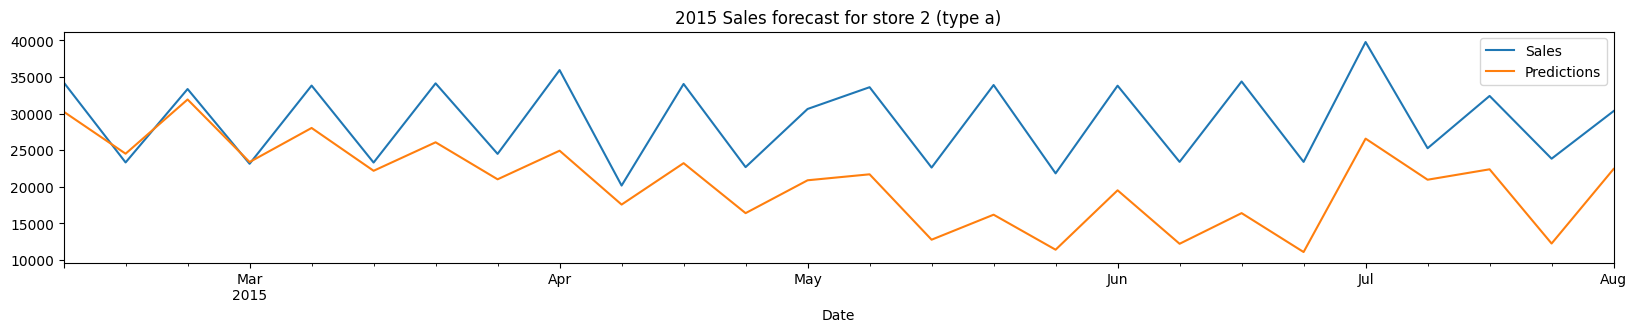

MAE: 8392.482165215692 -- MSE: 94643916.85874996


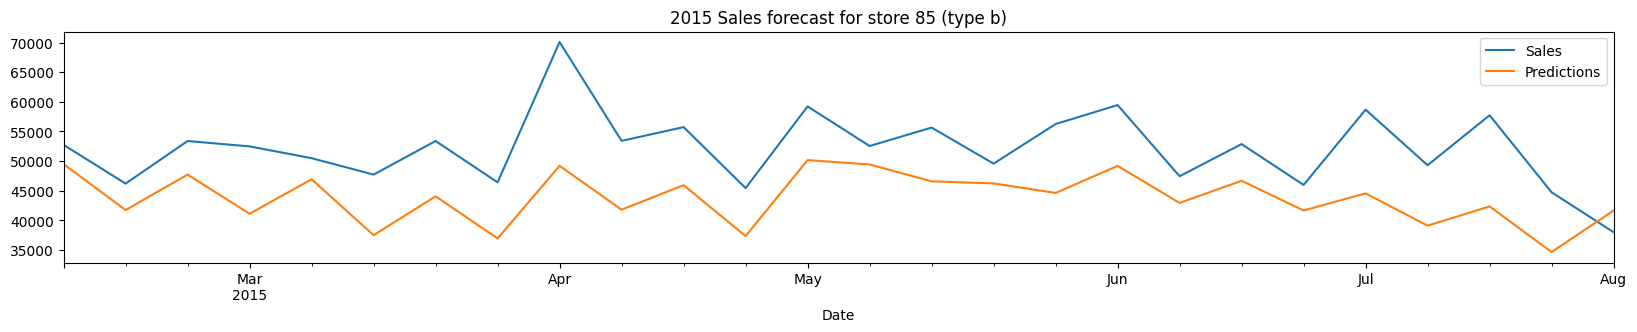

MAE: 8555.721002352566 -- MSE: 91257632.97858955


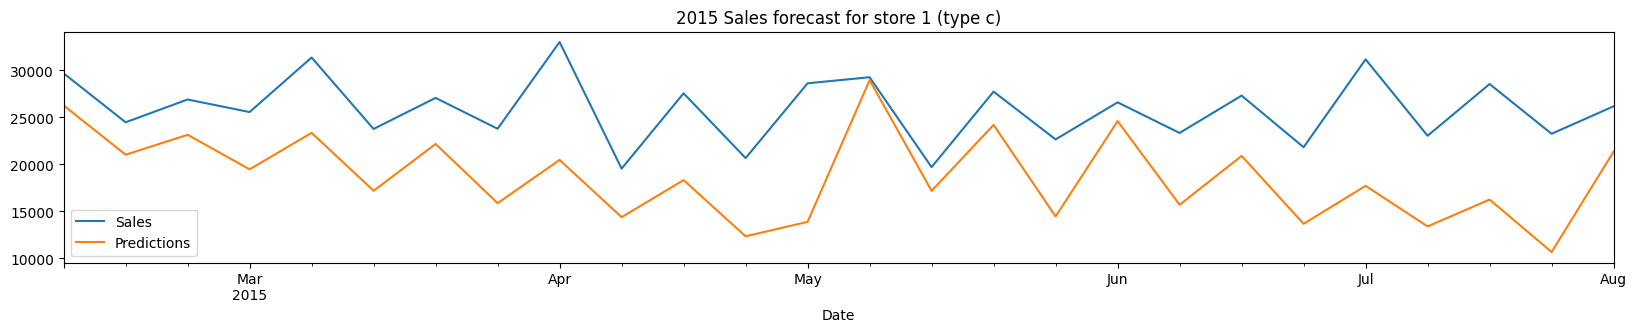

MAE: 7145.12820932966 -- MSE: 64958407.94978604


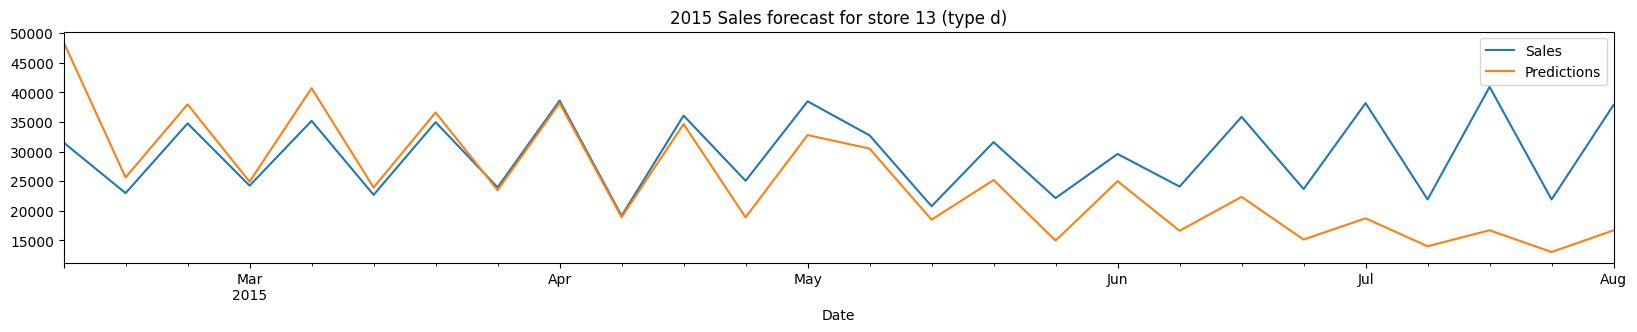

MAE: 6917.6290223004 -- MSE: 92146937.47725752


In [19]:
selected_stores = {
    "a": 2,
    "b": 85,
    "c": 1,
    "d": 13
}

for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[weekly_stores_sales_df.Store == store_id].set_index("Date")
    
    validation_sample = (
        validation_weekly_stores_sales_df[validation_weekly_stores_sales_df.Store == store_id].set_index("Date")
    )
    validation_trues = validation_sample.pop("Sales")
    
    results_df = get_forecast(validation_sample, history_df, xgbr_regressor)
    results_df["Sales"] = validation_trues
    
    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])
    
    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})");

    ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend();
    plt.show()
    
    print(f"MAE: {mae} -- MSE: {mse}")

The model tends to smooth out the peaks and troughs, which indicates a potential underfitting to sales volatility. Also, it's more accurate in capturing the trend for stores of type **c** and **a** compared to **b** and **d** stores.

In general, the forecasted values are closer to the actual sales for lower sales, but there is a consiste understimation of peak sales across all store types. Store types **d** and **b** show larger discrepancies between predicted and actual sales, indicating a need for store-specific model refinement.

# Store Type Specific Models

Now we'll try to boost forecastings accuracy by building store type specific models. We'll basically define 4 different models, one for each store type, and train them using data from the respective store types only. We'll conveniently store each model to a dict for ease of use later.

In [20]:
models_dict = {}

for type_id, store_type in enumerate(("a", "b", "c", "d")):
    sample_df = shuffled_weekly_stores_sales_df[
        shuffled_weekly_stores_sales_df.StoreType == type_id
    ]

    features, sales = (
        # We'll also get rid of the StoreType columns for training, as we don't need it anymore.
        sample_df.drop(["Sales", "StoreType"], axis="columns").values,
        sample_df[["Sales"]].values,
    )

    regressor = XGBRegressor()
    regressor.fit(features, sales)
    # Print some basic training metrics
    mae = mean_absolute_error(sales, regressor.predict(features))
    mse = mean_squared_error(sales, regressor.predict(features))
    print(
        f"Stores {store_type.upper()} Train MAE: {mae:.4f} -- Stores {store_type.upper()} MSE: {mse:.4f}"
    )
    
    # Store the resulting model in the dict.
    models_dict[store_type] = regressor

Stores A Train MAE: 0.0985 -- Stores A MSE: 0.0214
Stores B Train MAE: 0.0234 -- Stores B MSE: 0.0010
Stores C Train MAE: 0.0729 -- Stores C MSE: 0.0101
Stores D Train MAE: 0.0849 -- Stores D MSE: 0.0152


All training metrics are better than the general model built earlier, with the best fit for the store type **b** model.

Let's check how these models fare with the validation set.

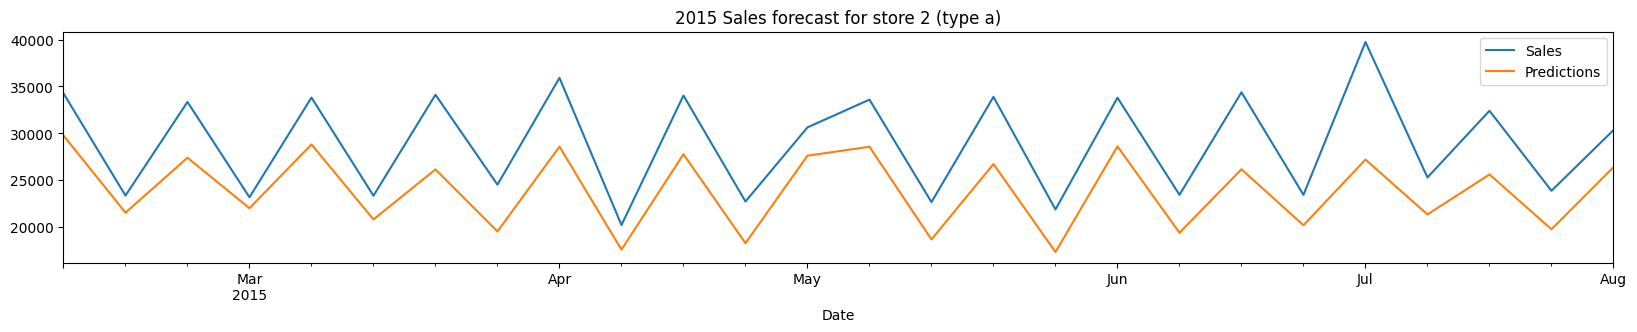

MAE: 5029.333069316183 -- MSE: 30756499.31828024


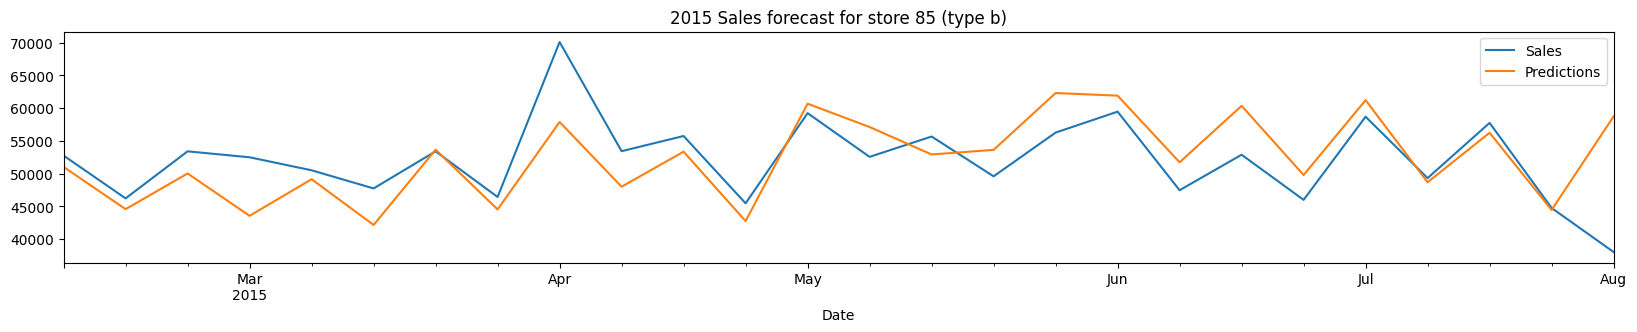

MAE: 4230.124238739726 -- MSE: 36159418.01475433


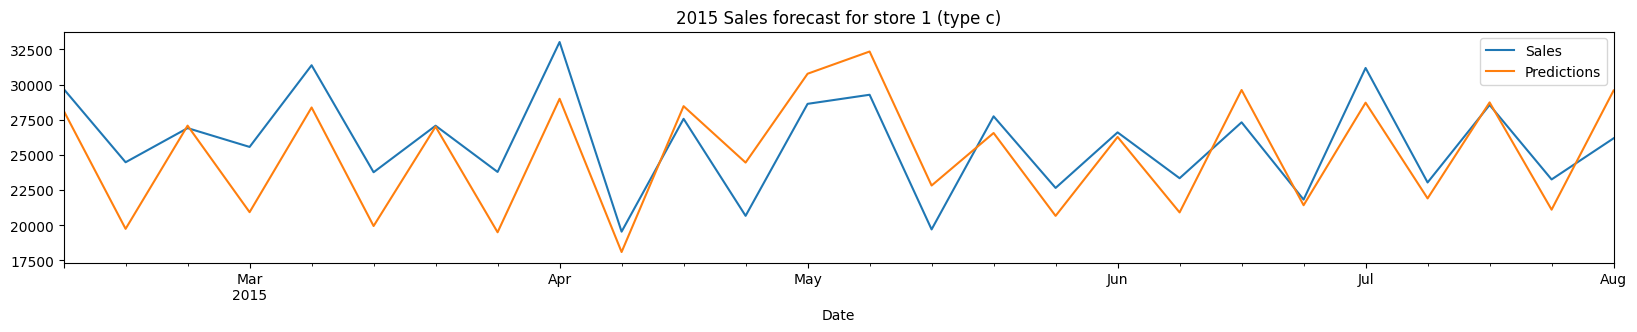

MAE: 2257.5398489750287 -- MSE: 7146791.872040506


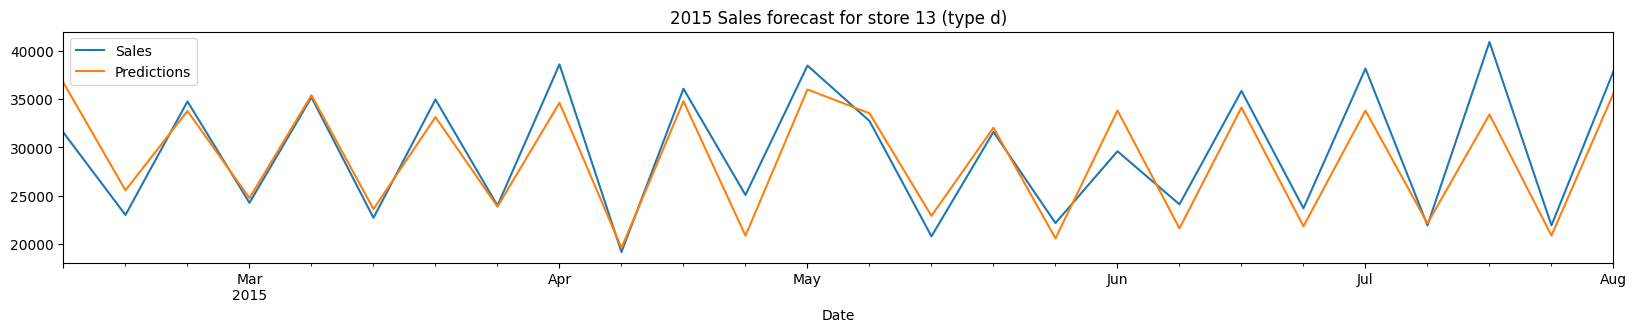

MAE: 2124.896182883803 -- MSE: 7694514.5954453135


In [21]:
for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[
        weekly_stores_sales_df.Store == store_id
    ].set_index("Date")

    validation_sample = validation_weekly_stores_sales_df[
        validation_weekly_stores_sales_df.Store == store_id
    ].set_index("Date")
    validation_trues = validation_sample.pop("Sales")
    validation_sample.pop("StoreType")

    regressor = models_dict[store_type]

    results_df = get_forecast(validation_sample, history_df, regressor)
    results_df["Sales"] = validation_trues

    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])

    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})")

    ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend()
    plt.show()

    print(f"MAE: {mae} -- MSE: {mse}")

The new type-specific models appear to have a much better fit with the actual sales data for their respective types. More specifically, types **b** and **d** models seems to better reflect the trend and magnitude of the actual sales.

In general, type-specific models seem to capture extreme sales values more accurately, which indicates that these models are likely incorporating the high variability in sales data.

We'll stop our analysis here, but in real world scenarios, it would be beneficial to continue refining these models with additional store-specific data and features to further improve their accuracy.